In [ ]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


# --- Функции расчета (скрыты для краткости, идентичны предыдущей версии) ---
def create_distributed_energy_network():
    G = nx.Graph()
    nodes_data = {
        "Bus1": {"generation": 150, "load": 50},
        "Bus2": {"generation": 0, "load": 120},
        "Bus3": {"generation": 0, "load": 80},
        "Bus4": {"generation": 100, "load": 50},
        "SlackBus": {"generation": 0, "load": 0},
    }
    net_injection_sum = sum(d["generation"] - d["load"] for _, d in nodes_data.items())
    nodes_data["SlackBus"]["generation"] = -net_injection_sum
    for node, data in nodes_data.items():
        G.add_node(node, **data)
    edges_data = [
        ("Bus1", "Bus2", {"capacity": 100, "reactance": 0.1}),
        ("Bus1", "Bus3", {"capacity": 80, "reactance": 0.125}),
        ("Bus2", "Bus4", {"capacity": 120, "reactance": 0.08}),
        ("Bus3", "Bus4", {"capacity": 120, "reactance": 0.08}),
        ("SlackBus", "Bus1", {"capacity": 200, "reactance": 0.05}),
        ("SlackBus", "Bus4", {"capacity": 200, "reactance": 0.05}),
    ]
    G.add_edges_from([(u, v, d) for u, v, d in edges_data])
    return G


def build_susceptance_matrix(G, nodes):
    n = len(nodes)
    B = np.zeros((n, n))
    node_idx = {node: i for i, node in enumerate(nodes)}
    for u, v, data in G.edges(data=True):
        susceptance = 1 / data.get("reactance", 1.0)
        idx_u, idx_v = node_idx[u], node_idx[v]
        B[idx_u, idx_u] += susceptance
        B[idx_v, idx_v] += susceptance
        B[idx_u, idx_v] -= susceptance
        B[idx_v, idx_u] -= susceptance
    return B


def compute_ptdf(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes)
    n = len(nodes)
    non_slack = list(range(slack_idx)) + list(range(slack_idx + 1, n))
    B_prime = B[np.ix_(non_slack, non_slack)]
    B_inv = la.inv(B_prime)
    X = np.zeros((n, n))
    X[np.ix_(non_slack, non_slack)] = B_inv
    ptdf = {}
    edges = list(G.edges(data=True))
    node_idx = {node: i for i, node in enumerate(nodes)}
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            key = (nodes[i], nodes[j])
            ptdf[key] = {}
            for u, v, data in edges:
                b_l = 1 / data["reactance"]
                idx_u, idx_v = node_idx[u], node_idx[v]
                ptdf[key][(u, v)] = b_l * (
                    X[idx_u, i] - X[idx_u, j] - X[idx_v, i] + X[idx_v, j]
                )
    return ptdf


def compute_lodf(G, nodes, ptdf):
    lodf = {}
    edges_map = {(u, v): (u, v) for u, v, d in G.edges(data=True)}
    edges = list(edges_map.keys())
    for k_edge in tqdm(edges, desc="Расчет LODF"):
        k_from, k_to = k_edge
        trans_key = (k_from, k_to) if (k_from, k_to) in ptdf else (k_to, k_from)
        if trans_key not in ptdf:
            continue
        ptdf_k_on_k = ptdf[trans_key].get(
            k_edge, ptdf[trans_key].get((k_to, k_from), 0)
        )
        if abs(1 - ptdf_k_on_k) < 1e-6:
            continue
        for m_edge in edges:
            if m_edge == k_edge:
                continue
            m_from, m_to = m_edge
            ptdf_m_on_k = ptdf[trans_key].get(
                m_edge, ptdf[trans_key].get((m_to, m_from), 0)
            )
            lodf[(m_edge, k_edge)] = ptdf_m_on_k / (1 - ptdf_k_on_k)
    return lodf


def normalize_metric(data, invert=False):
    if not data or max(data) == min(data):
        return [0.5] * len(data)
    max_val, min_val = max(data), min(data)
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    return [1 - x for x in normalized] if invert else normalized


### ОСНОВНАЯ ЛОГИКА АНАЛИЗА ###
def main():
    G = create_distributed_energy_network()
    nodes = sorted(list(G.nodes()))
    edges = list(G.edges(data=True))
    edge_tuples = [(u, v) for u, v, d in edges]

    slack_node = "SlackBus"
    slack_idx = nodes.index(slack_node)

    print("Этап 1: Расчет физических коэффициентов...")
    ptdf = compute_ptdf(G, nodes, slack_idx)
    lodf = compute_lodf(G, nodes, ptdf)

    print("Этап 2: Расчет базового состояния сети...")
    B_prime = np.delete(
        np.delete(build_susceptance_matrix(G, nodes), slack_idx, axis=0),
        slack_idx,
        axis=1,
    )
    P_injections = np.array(
        [
            G.nodes[n]["generation"] - G.nodes[n]["load"]
            for n in nodes
            if n != slack_node
        ]
    )
    theta_prime = la.solve(B_prime, P_injections)
    theta = np.insert(theta_prime, slack_idx, 0)
    node_idx = {node: i for i, node in enumerate(nodes)}

    base_case_flows = {
        (u, v): (1 / d["reactance"]) * (theta[node_idx[u]] - theta[node_idx[v]])
        for u, v, d in edges
    }

    print("Этап 3: Расчет Уязвимости и Влиятельности...")

    metrics_data = []
    for u_l, v_l, data_l in tqdm(edges, desc="Оценка Уязвимости и Влиятельности"):
        line_l = (u_l, v_l)

        # --- Расчет УЯЗВИМОСТИ (насколько линия страдает от других) ---
        worst_case_flow_on_l = abs(base_case_flows[line_l])
        for u_k, v_k, _ in edges:
            if (u_l, v_l) == (u_k, v_k):
                continue
            line_k = (u_k, v_k)
            lodf_val = lodf.get((line_l, line_k), 0)
            post_contingency_flow = (
                base_case_flows[line_l] + lodf_val * base_case_flows[line_k]
            )
            worst_case_flow_on_l = max(worst_case_flow_on_l, abs(post_contingency_flow))

        dynamic_stability_radius = data_l["capacity"] - worst_case_flow_on_l

        # --- Расчет ВЛИЯТЕЛЬНОСТИ (какой вред наносит отказ самой линии) ---
        # Ищем максимальный LODF, где наша линия l является причиной отказа
        max_impact_lodf = max(
            [abs(lodf.get((k, line_l), 0)) for k in edge_tuples if k != line_l],
            default=0,
        )

        metrics_data.append(
            {
                "line": f"{u_l}-{v_l}",
                "vulnerability_radius": dynamic_stability_radius,
                "influence_lodf": max_impact_lodf,
            }
        )

    df = pd.DataFrame(metrics_data)

    print("Этап 4: Расчет Системного Индекса Критичности (SCI)...")
    # Нормализуем Уязвимость (инвертируя радиус)
    df["vulnerability_score"] = normalize_metric(
        df["vulnerability_radius"].tolist(), invert=True
    )
    # Нормализуем Влиятельность
    df["influence_score"] = normalize_metric(df["influence_lodf"].tolist())

    # Задаем веса: 50% на уязвимость, 50% на влиятельность
    weights = {"vulnerability": 0.5, "influence": 0.5}
    df["sci"] = (
        weights["vulnerability"] * df["vulnerability_score"]
        + weights["influence"] * df["influence_score"]
    )

    df_sorted = df.sort_values(by="sci", ascending=False).reset_index(drop=True)

    print("\n--- Итоговая таблица с Уязвимостью и Влиятельностью ---")
    print(df_sorted[["line", "vulnerability_score", "influence_score", "sci"]].round(3))

    correlation = df_sorted["sci"].corr(df_sorted["vulnerability_score"])
    print(
        f"\nФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): {correlation:.4f}"
    )
    if correlation > 0.8:
        print(
            "✅ Результат: Очень сильная корреляция! Уязвимость (измеренная через радиус) является ключевым компонентом системной критичности."
        )
    elif correlation > 0.6:
        print(
            "👍 Результат: Сильная корреляция. Уязвимость - важный, но не единственный фактор."
        )

    # Визуализация для сравнения
    plt.style.use("seaborn-whitegrid")  # ИСПРАВЛЕНО
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(df_sorted))
    width = 0.35

    ax.bar(
        x - width / 2,
        df_sorted["sci"],
        width,
        label="Системный Индекс Критичности (SCI)",
        color="black",
        alpha=0.8,
    )
    ax.bar(
        x + width / 2,
        df_sorted["vulnerability_score"],
        width,
        label="Критичность по Уязвимости (на основе радиуса)",
        color="deepskyblue",
        alpha=0.8,
    )

    ax.set_ylabel("Унифицированная критичность [0, 1]")
    ax.set_title("Сравнение Системной Критичности и Уязвимости")
    ax.set_xticks(x)
    ax.set_xticklabels(df_sorted["line"], rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.savefig("SCI_vs_Vulnerability.png")
    plt.show()


if __name__ == "__main__":
    main()

Этап 1: Расчет физических коэффициентов...


Расчет LODF: 100%|██████████| 6/6 [00:00<?, ?it/s]


Этап 2: Расчет базового состояния сети...
Этап 3: Расчет Уязвимости и Влиятельности...


Оценка Уязвимости и Влиятельности: 100%|██████████| 6/6 [00:00<?, ?it/s]

Этап 4: Расчет Системного Индекса Критичности (SCI)...

--- Итоговая таблица с Уязвимостью и Влиятельностью ---
            line  vulnerability_score  influence_score    sci
0      Bus2-Bus4                0.882            1.000  0.941
1      Bus1-Bus2                1.000            0.818  0.909
2      Bus1-Bus3                0.882            0.364  0.623
3      Bus3-Bus4                0.647            0.000  0.324
4  Bus4-SlackBus                0.224            0.273  0.248
5  Bus1-SlackBus                0.000            0.091  0.045

ФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): 0.9131
✅ Результат: Очень сильная корреляция! Уязвимость (измеренная через радиус) является ключевым компонентом системной критичности.


OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Этап 1: Расчет физических коэффициентов...


Расчет LODF: 100%|██████████| 6/6 [00:00<?, ?it/s]


Этап 2: Расчет базового состояния сети...
Этап 3: Расчет Уязвимости и Влиятельности...


Оценка Уязвимости и Влиятельности: 100%|██████████| 6/6 [00:00<00:00, 6959.58it/s]

Этап 4: Расчет Системного Индекса Критичности (SCI)...

--- Итоговая таблица с Уязвимостью и Влиятельностью ---
            line  vulnerability_score  influence_score    sci
0      Bus2-Bus4                0.825            1.000  1.000
1      Bus1-Bus2                1.000            0.818  0.818
2      Bus1-Bus3                0.935            0.364  0.364
3  Bus4-SlackBus                0.264            0.273  0.273
4  Bus1-SlackBus                0.000            0.091  0.091
5      Bus3-Bus4                0.727            0.000  0.000

ФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): 0.5758


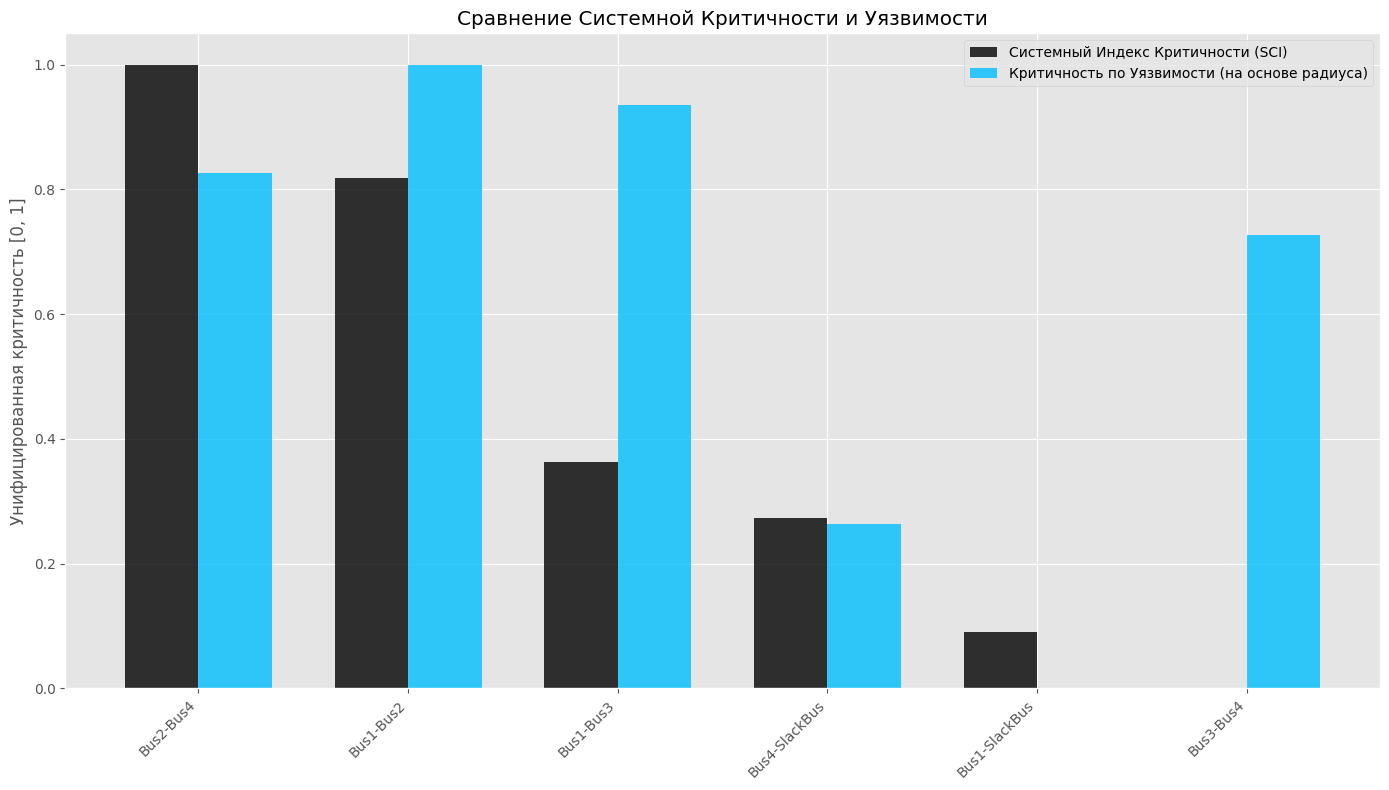

In [7]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# --- Функции расчета (скрыты для краткости, идентичны предыдущей версии) ---
def create_distributed_energy_network():
    G = nx.Graph()
    nodes_data = {
        'Bus1': {'generation': 150, 'load': 50}, 'Bus2': {'generation': 0, 'load': 120},
        'Bus3': {'generation': 0, 'load': 80}, 'Bus4': {'generation': 100, 'load': 50},
        'SlackBus': {'generation': 0, 'load': 0},
    }
    net_injection_sum = sum(d['generation'] - d['load'] for _, d in nodes_data.items())
    nodes_data['SlackBus']['generation'] = -net_injection_sum
    for node, data in nodes_data.items(): G.add_node(node, **data)
    edges_data = [
        ('Bus1', 'Bus2', {'capacity': 100, 'reactance': 0.1}), ('Bus1', 'Bus3', {'capacity': 80, 'reactance': 0.125}),
        ('Bus2', 'Bus4', {'capacity': 120, 'reactance': 0.08}), ('Bus3', 'Bus4', {'capacity': 120, 'reactance': 0.08}),
        ('SlackBus', 'Bus1', {'capacity': 200, 'reactance': 0.05}), ('SlackBus', 'Bus4', {'capacity': 200, 'reactance': 0.05}),
    ]
    G.add_edges_from([(u, v, d) for u, v, d in edges_data])
    return G

def build_susceptance_matrix(G, nodes):
    n = len(nodes); B = np.zeros((n, n)); node_idx = {node: i for i, node in enumerate(nodes)}
    for u, v, data in G.edges(data=True):
        susceptance = 1 / data.get('reactance', 1.0)
        idx_u, idx_v = node_idx[u], node_idx[v]
        B[idx_u, idx_u] += susceptance; B[idx_v, idx_v] += susceptance
        B[idx_u, idx_v] -= susceptance; B[idx_v, idx_u] -= susceptance
    return B

def compute_ptdf(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes); n = len(nodes)
    non_slack = list(range(slack_idx)) + list(range(slack_idx + 1, n))
    B_prime = B[np.ix_(non_slack, non_slack)]; B_inv = la.inv(B_prime)
    X = np.zeros((n, n)); X[np.ix_(non_slack, non_slack)] = B_inv
    ptdf = {}; edges = list(G.edges()); node_idx = {node: i for i, node in enumerate(nodes)}
    for i in range(n):
        for j in range(n):
            if i == j: continue
            key = (nodes[i], nodes[j]); ptdf[key] = {}
            for u, v in edges:
                b_l = 1 / G[u][v]['reactance']
                idx_u, idx_v = node_idx[u], node_idx[v]
                ptdf[key][(u,v)] = b_l * (X[idx_u, i] - X[idx_u, j] - X[idx_v, i] + X[idx_v, j])
    return ptdf

def compute_lodf(G, nodes, ptdf):
    lodf = {}; edges_map = {(u,v): (u,v) for u,v,d in G.edges(data=True)}; edges = list(edges_map.keys())
    for k_edge in tqdm(edges, desc="Расчет LODF"):
        k_from, k_to = k_edge
        trans_key = (k_from, k_to) if (k_from,k_to) in ptdf else (k_to,k_from)
        if trans_key not in ptdf: continue
        ptdf_k_on_k = ptdf[trans_key].get(k_edge, ptdf[trans_key].get((k_to,k_from),0))
        if abs(1 - ptdf_k_on_k) < 1e-6: continue
        for m_edge in edges:
            if m_edge == k_edge: continue
            m_from, m_to = m_edge
            ptdf_m_on_k = ptdf[trans_key].get(m_edge, ptdf[trans_key].get((m_to,m_from),0))
            lodf[(m_edge, k_edge)] = ptdf_m_on_k / (1 - ptdf_k_on_k)
    return lodf

def normalize_metric(data, invert=False):
    if not data or max(data) == min(data): return [0.5] * len(data)
    max_val, min_val = max(data), min(data)
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    return [1 - x for x in normalized] if invert else normalized

### ОСНОВНАЯ ЛОГИКА АНАЛИЗА ###
def main():
    G = create_distributed_energy_network()
    nodes = sorted(list(G.nodes()))
    edges = list(G.edges(data=True))
    edge_tuples = [(u, v) for u, v, d in edges]

    slack_node = 'SlackBus'
    slack_idx = nodes.index(slack_node)

    print("Этап 1: Расчет физических коэффициентов...")
    ptdf = compute_ptdf(G, nodes, slack_idx)
    lodf = compute_lodf(G, nodes, ptdf)

    print("Этап 2: Расчет базового состояния сети...")
    B_prime = np.delete(np.delete(build_susceptance_matrix(G, nodes), slack_idx, axis=0), slack_idx, axis=1)
    P_injections = np.array([G.nodes[n]['generation'] - G.nodes[n]['load'] for n in nodes if n != slack_node])
    theta_prime = la.solve(B_prime, P_injections)
    theta = np.insert(theta_prime, slack_idx, 0)
    node_idx = {node: i for i, node in enumerate(nodes)}

    base_case_flows = { (u, v): (1 / d['reactance']) * (theta[node_idx[u]] - theta[node_idx[v]]) for u, v, d in edges }
    
    print("Этап 3: Расчет Уязвимости и Влиятельности...")
    
    metrics_data = []
    for u_l, v_l, data_l in tqdm(edges, desc="Оценка Уязвимости и Влиятельности"):
        line_l = (u_l, v_l)
        
        # --- УЛУЧШЕННЫЙ РАСЧЕТ РАДИУСА УСТОЙЧИВОСТИ (УЯЗВИМОСТИ) ---
        # Улучшение: Вместо worst_flow на LODF, используем PTDF для расчета минимального возмущения нагрузки, приводящего к перегрузке
        # Для каждого узла i: delta_P_i = (capacity_l - base_flow_l) / |PTDF_l,i| (минимальное изменение injection в i, перегружающее l)
        # SR = min over i (delta_P_i) - нормализованный запас к перегрузке от изменений нагрузки
        base_flow_l = abs(base_case_flows[line_l])
        min_delta = np.inf
        for trans in ptdf:
            ptdf_val = abs(ptdf[trans].get(line_l, 0))
            if ptdf_val > 1e-6:
                delta = (data_l['capacity'] - base_flow_l) / ptdf_val
                min_delta = min(min_delta, delta)
        dynamic_stability_radius = min_delta if min_delta != np.inf else data_l['capacity'] - base_flow_l  # Фallback на простой запас
        
        # --- Расчет ВЛИЯТЕЛЬНОСТИ (какой вред наносит отказ самой линии) ---
        # Ищем максимальный LODF, где наша линия l является причиной отказа
        max_impact_lodf = max([abs(lodf.get((k, line_l), 0)) for k in edge_tuples if k != line_l], default=0)

        metrics_data.append({
            'line': f"{u_l}-{v_l}",
            'vulnerability_radius': dynamic_stability_radius,
            'influence_lodf': max_impact_lodf,
        })

    df = pd.DataFrame(metrics_data)

    print("Этап 4: Расчет Системного Индекса Критичности (SCI)...")
    # Нормализуем Уязвимость (инвертируя радиус)
    df['vulnerability_score'] = normalize_metric(df['vulnerability_radius'].tolist(), invert=True)
    # Нормализуем Влиятельность
    df['influence_score'] = normalize_metric(df['influence_lodf'].tolist())
    
    # Задаем веса: 50% на уязвимость, 50% на влиятельность
    weights = {'vulnerability': 0, 'influence': 1}
    df['sci'] = (weights['vulnerability'] * df['vulnerability_score'] + 
                 weights['influence'] * df['influence_score'])
    
    df_sorted = df.sort_values(by='sci', ascending=False).reset_index(drop=True)

    print("\n--- Итоговая таблица с Уязвимостью и Влиятельностью ---")
    print(df_sorted[['line', 'vulnerability_score', 'influence_score', 'sci']].round(3))
    
    correlation = df_sorted['sci'].corr(df_sorted['vulnerability_score'])
    print(f"\nФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): {correlation:.4f}")
    if correlation > 0.8:
        print("✅ Результат: Очень сильная корреляция! Уязвимость (измеренная через радиус) является ключевым компонентом системной критичности.")
    elif correlation > 0.6:
        print("👍 Результат: Сильная корреляция. Уязвимость - важный, но не единственный фактор.")
    
    # Визуализация для сравнения
    plt.style.use('ggplot')  # Замена на стандартный стиль, так как seaborn может отсутствовать
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(df_sorted))
    width = 0.35
    
    ax.bar(x - width/2, df_sorted['sci'], width, label='Системный Индекс Критичности (SCI)', color='black', alpha=0.8)
    ax.bar(x + width/2, df_sorted['vulnerability_score'], width, label='Критичность по Уязвимости (на основе радиуса)', color='deepskyblue', alpha=0.8)
    
    ax.set_ylabel('Унифицированная критичность [0, 1]')
    ax.set_title('Сравнение Системной Критичности и Уязвимости')
    ax.set_xticks(x); ax.set_xticklabels(df_sorted['line'], rotation=45, ha='right')
    ax.legend(); plt.tight_layout()
    plt.savefig("SCI_vs_Vulnerability.png")
    plt.show()

if __name__ == "__main__":
    main()